# Tree-Based Forecasting

We show how to extend tree-based models to time series forecasting

## What we will accomplish

In this notebook we will:
- Touch on how to extend tree-based models building forecasts,
- Talk about moving windows for time series, and
- Learn the `.shift` function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
set_style("whitegrid")

<blockquote>
    This notebook should be consumed after you learn about decision trees and random forests.
</blockquote>

While we initially covered tree-based methods (decision trees and random forests) as a classification algorithm they can also be used to build forecasts.

## Autoregression

They do this by turning the task of forecasting into an autoregression problem. Recall that autoregression refers to the regressing of a time series onto itself. For example, for a time series, $y_t$, an autoregression model of order three would be regressing $y_t$ onto $y_{t-1}, \ y_{t-2},$ and $y_{t-3}$. Such models can be approximated with tree-based methods, but it will require some time series data preprocessing on our part.

## Moving windows

When fitting an `sklearn` decision tree or random forest model we needed an array `X` containing features and an array `y` that we want to predict. However, in many time series problems we just have an array `y`. We have to create an `X` using just `y` using <i>moving windows</i>. For example, if we are fitting an autoregression of order three we would move a sliding "window" along the time series. Every three consecutive time steps will be separated off into the rows of `X` with the next step being placed in a new target array. This process is illustrated for a training set of size $10$ below:

<img src="ts_shift.png" width=90%></img>

We can accomplish this preprocessing relatively easily with `pandas` `.shift()` function, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html</a>. Let's see this with the Google stock price data.

In [2]:
goog = pd.read_csv("../../../data/google_stock.csv",
                   parse_dates=['date'])

## train test split
goog_train = goog.iloc[:-14].copy()
goog_test = goog.iloc[-14:].copy()

`.shift()` takes in a positive integer, `n`, and then shifts the entries of the `Series` or `DataFrame` `n` units forward.

In [3]:
goog_train.closing_price.head(6)

0    49.982655
1    53.952770
2    54.495735
3    52.239197
4    52.802086
5    53.753517
Name: closing_price, dtype: float64

In [5]:
## the closing_price column moves ahead 3 rows
goog_train.closing_price.shift(3).head(6)

0          NaN
1          NaN
2          NaN
3    49.982655
4    53.952770
5    54.495735
Name: closing_price, dtype: float64

We can combine this with a `list` comprehension and `np.concatenate` to get an array of three-entry windows for the entire time series.

In [6]:
## The list comprehension collects the t=1, t=2, t=3 shifts into a list
## We then change the resulting arrays into columns with reshape(-1,1)
[goog_train.closing_price.shift(t).values.reshape(-1,1) for t in range(1,4)]

[array([[        nan],
        [  49.982655],
        [  53.95277 ],
        ...,
        [2695.030029],
        [2686.159912],
        [2642.439941]]),
 array([[        nan],
        [        nan],
        [  49.982655],
        ...,
        [2683.360107],
        [2695.030029],
        [2686.159912]]),
 array([[        nan],
        [        nan],
        [        nan],
        ...,
        [2697.820068],
        [2683.360107],
        [2695.030029]])]

In [8]:
## np.concatenate will concatenate the three columns so the resulting
## array has three columns
np.concatenate([goog_train.closing_price.shift(t).values.reshape(-1,1) for t in range(1,4)], axis=1)[:6, :]

array([[      nan,       nan,       nan],
       [49.982655,       nan,       nan],
       [53.95277 , 49.982655,       nan],
       [54.495735, 53.95277 , 49.982655],
       [52.239197, 54.495735, 53.95277 ],
       [52.802086, 52.239197, 54.495735]])

In [9]:
## we then ditch the first three rows because they have missing values
print("            y_{t-1},   y_{t-2},     y_{t-3}")
np.concatenate([goog_train.closing_price.shift(t).values.reshape(-1,1) for t in range(1,4)], axis=1)[3:]

            y_{t-1},   y_{t-2},     y_{t-3}


array([[  54.495735,   53.95277 ,   49.982655],
       [  52.239197,   54.495735,   53.95277 ],
       [  52.802086,   52.239197,   54.495735],
       ...,
       [2695.030029, 2683.360107, 2697.820068],
       [2686.159912, 2695.030029, 2683.360107],
       [2642.439941, 2686.159912, 2695.030029]])

In [10]:
window_size = 3

## Now we store it in an array called X_train
X_train = np.concatenate([goog_train.closing_price.shift(t).values.reshape(-1,1) for t in range(1,window_size)], 
                         axis=1)[window_size:]

In [11]:
## to get y_train we just take from the 4th entry onward
y_train = goog_train.closing_price.values[window_size:]

Now that we have `X_train` and `y_train` we can train a decision tree or random forest regressor model. These are `DecisionTreeRegressor` in `sklearn.tree` or `RandomForestRegressor` in `sklearn.ensemble`.

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [13]:
max_depth = 5

tree = DecisionTreeRegressor(max_depth=max_depth)
rf = RandomForestRegressor(max_depth=max_depth)

tree.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

Now that the models are trained you make your forecast by propagating the prediction from the most recent observations to the horizon.

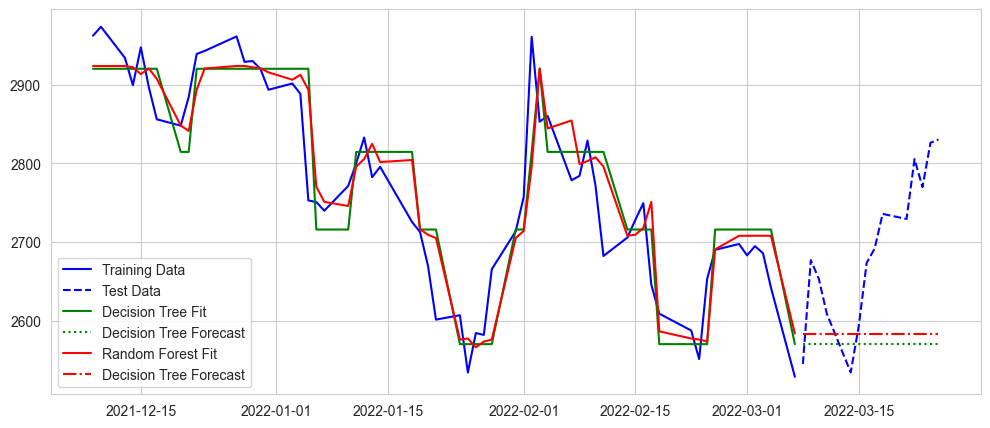

In [14]:
## plotting the fit for both models
plt.figure(figsize=(12,5))

plt.plot(goog_train.date.values[-60:], 
         goog_train.closing_price.values[-60:],
         'b-',
         label='Training Data')

plt.plot(goog_test.date.values[-60:], 
         goog_test.closing_price.values[-60:],
         'b--',
         label='Test Data')


plt.plot(goog_train.date.values[-60:],
          tree.predict(X_train)[-60:],
          'g',
          label="Decision Tree Fit")

plt.plot(goog_test.date,
          tree.predict(X_train)[-1]*np.ones(len(goog_test)),
          'g:',
          label="Decision Tree Forecast")


plt.plot(goog_train.date.values[-60:],
          rf.predict(X_train)[-60:],
          'r',
          label="Random Forest Fit")

plt.plot(goog_test.date,
          rf.predict(X_train)[-1]*np.ones(len(goog_test)),
          'r-.',
          label="Decision Tree Forecast")

plt.legend()

plt.show()

### Dealing with trends

If you have data with a trend, like our stock market data, we can improve a tree-based forecast by modeling the first differences instead of directly forecasting the time series.

Recall that $\Delta y_{t} = y_t - y_{t-1}$ is the first difference at $t$ and thus:
$$
y_{t+1} = \Delta y_{t+1} + y_t
$$

Instead of directly predicting $y_{t+1}$ using the past $n$ observations you can predict $\Delta y_{t+1}$ using the past $n$ differences and so:
$$
\hat{y_{t+1}} = \hat{\Delta y_{t+1}} + y_t
$$

for observations more than one step beyond the training set you can use the following:
$$
\hat{y_{t+h}} = h\hat{\Delta y_{t+1}} + y_t.
$$

Let's try and implement this for the Google data.

In [15]:
## Remember you can get the first differences with .diff()
goog_train.closing_price.diff()

0              NaN
1         3.970115
2         0.542965
3        -2.256538
4         0.562889
           ...    
4413    -14.459961
4414     11.669922
4415     -8.870117
4416    -43.719971
4417   -113.149902
Name: closing_price, Length: 4418, dtype: float64

In [16]:
window_size = 3

## Remaking X_train
X_train = np.concatenate([goog_train.closing_price.diff()[1:].shift(t).values.reshape(-1,1) for t in range(1,window_size+1)], 
                         axis=1)[window_size:]

## Remaking y_train
y_train = goog_train.closing_price.diff()[1:][window_size:]

In [17]:
rf = RandomForestRegressor(max_depth = 5)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

In [21]:
## the fit to the training data 
## The predicted deltas plus the most recently observed time step
rf_fit = rf.predict(X_train) + goog_train.closing_price[window_size+1:]

## The forecast
## Taking the last predicted delta * h plus the last observed value in the training set
rf_pred = rf.predict(X_train)[-1]*np.arange(1, len(goog_test)+1) + goog_train.closing_price.values[-1]

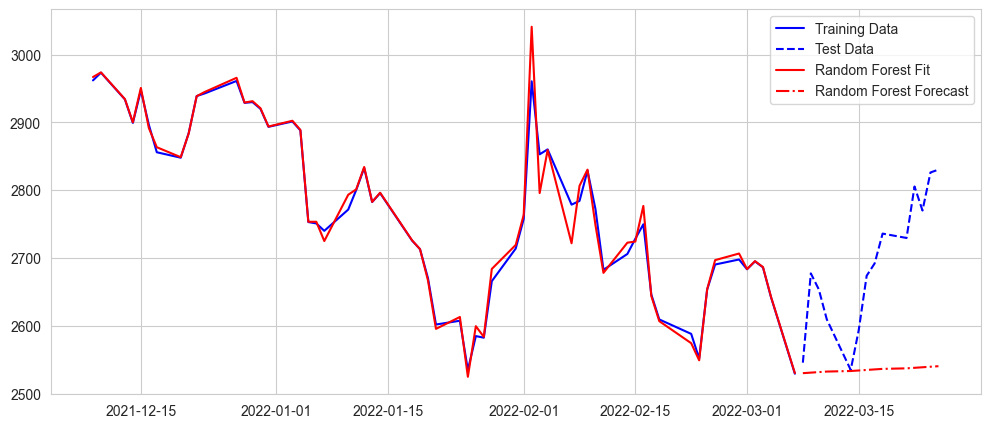

In [22]:
## plotting the fit for both models
plt.figure(figsize=(12,5))

plt.plot(goog_train.date.values[-60:], 
         goog_train.closing_price.values[-60:],
         'b-',
         label='Training Data')

plt.plot(goog_test.date.values[-60:], 
         goog_test.closing_price.values[-60:],
         'b--',
         label='Test Data')

plt.plot(goog_train.date.values[-60:],
          rf_fit[-60:],
          'r',
          label="Random Forest Fit")

plt.plot(goog_test.date,
          rf_pred,
          'r-.',
          label="Random Forest Forecast")

plt.legend()

plt.show()

### Including other regressors

Like ARIMA, tree-based regressors can also include other features in addition to the time series. For example, if we had data, $X_t$, on business fundamentals that we expect impacts the value of the stock we could include such data as inputs to our tree-based model.

We now have a good introduction into tree-based forecasts.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)